In [79]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import base64

spotify_data = pd.read_json("StreamingHistory1.json")
time_data = spotify_data['endTime']
dates_list = []
times_list = []
for item in time_data:
    values = item.split(' ')
    dates_list.append(values[0])
    times_list.append(values[1])
d = {'dates': dates_list, 'times': times_list}
split_df = pd.DataFrame(d)
extract_df = pd.DataFrame([spotify_data["artistName"], spotify_data["trackName"], spotify_data["msPlayed"]])
spotify_data = spotify_data.drop(columns=['endTime'])
final_df = pd.concat([split_df, spotify_data], axis=1, ignore_index=True)
mlseconds = final_df[4]
minutes = []
for i in mlseconds:
    minutes.append(round(i/6000, 2))
final_df['minutes'] = minutes
final_df = final_df.drop(columns=[4])
print(final_df)

final_df.to_csv("final.csv")

               0      1                     2                     3  minutes
0     2021-07-01  00:04  Bring Me The Horizon         fresh bruises    33.08
1     2021-07-01  00:07              Verzache        Losing My Love    28.96
2     2021-07-01  00:10            Rich Brian                  Cold    38.07
3     2021-07-01  00:14           Post Malone  Broken Whiskey Glass     4.70
4     2021-07-01  00:14                  Joji               Will He    33.68
...          ...    ...                   ...                   ...      ...
4448  2021-09-29  04:45                  MINO                ROCKET    31.87
4449  2021-09-29  04:46          99 Neighbors             Bangarang     8.80
4450  2021-09-29  04:49           Pink Sweat$               Honesty    31.50
4451  2021-09-29  04:52                 keshi         like i need u    30.45
4452  2021-09-29  04:54              Doja Cat               Streets    20.29

[4453 rows x 5 columns]


In [80]:
time_data['date'] = final_df[0] 
time_data['minutes'] = final_df['minutes']
dates = []
total_minutes = []
prev_date = time_data['date'][0]
current_date = ""
total_time = 0

for i in range(len(time_data['date'])) :
    current_date = time_data['date'][i]
    if current_date == prev_date:
        total_time = round(total_time + time_data['minutes'][i], 2)
    if current_date != prev_date:
        dates.append(prev_date)
        total_minutes.append(total_time)
        total_time = 0
    prev_date = current_date
dates.append(current_date)
total_minutes.append(total_time)

daily_time = pd.DataFrame(dates, columns=['date'])
daily_time['total_time'] = total_minutes
print(daily_time)

          date  total_time
0   2021-07-01      310.08
1   2021-07-02      868.46
2   2021-07-03      202.52
3   2021-07-05     1258.68
4   2021-07-06      367.37
..         ...         ...
78  2021-09-25     2772.11
79  2021-09-26      258.72
80  2021-09-27      264.92
81  2021-09-28      493.04
82  2021-09-29      527.59

[83 rows x 2 columns]


In [81]:
# obtain daily weather data for 01/01/2021 until 10/20/2021 (I used the 20th because any later date made it error out)
daily_url = "https://meteostat.p.rapidapi.com/stations/daily"
daily_url += "?station=" + "KSFF0"
daily_url += "&start=2021-07-01&end=2021-09-29&units=imperial"
daily_headers = {"x-rapidapi-key": "381cae8b55msh32063fc585da174p17432djsn6a4de74c8bbf"}
response = requests.get(url=daily_url, headers=daily_headers)
json_obj = json.loads(response.text)
data_obj = json_obj['data']
#load data_obj into a data frame and set the headers. 
df = pd.DataFrame(data_obj, columns= ['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun'])
#replace values that are missing with np.nan so I can later use .isnull().mean()
df = df.fillna(value=np.nan)
# takes the average of isnulls within the column and creates a new dataframe with columns that only contain less than 75% of NaNs
df = df[df.columns[(df.isnull().mean() < 0.75)]]
#cleans up the data frame by filling NaNs 
df = df.interpolate(method='linear')
df = df.ffill()
df = df.bfill()
# prints out the cleaned data to a csv
df.to_csv("Spokane_daily_weather_cleaned.csv")


In [83]:
artists = final_df[2]
genres = []



0       Bring Me The Horizon
1                   Verzache
2                 Rich Brian
3                Post Malone
4                       Joji
                ...         
4448                    MINO
4449            99 Neighbors
4450             Pink Sweat$
4451                   keshi
4452                Doja Cat
Name: 2, Length: 4453, dtype: object


Text(0.5, 1.0, 'Daily Listening Time')

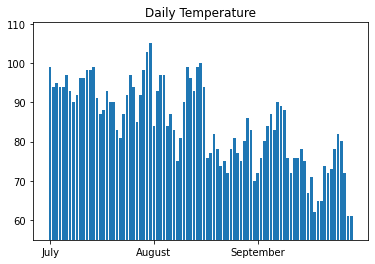

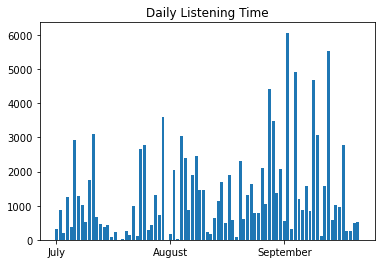

In [82]:


dates = df["date"]
temp = df["tmax"]
plt.bar(dates,temp)
plt.ylim(55)
plt.xlim(-5,95)
plt.xticks([0,31,62], ('July', 'August', 'September'))
plt.title("Daily Temperature")

x = daily_time['date']
y = daily_time['total_time']
plt.figure()
plt.bar(x, y)
plt.xticks([0,31,62], ('July', 'August', 'September'))
plt.title("Daily Listening Time")